In [4]:
import numpy as np
import torch
from intrinsics_dimension import twonn_pytorch
import os
import yaml

In [ ]:
SAVE_STATS_PATH = 'all_stats/openLlama3B_topic_Bird'
DIRNAME = 'activations_topics/open_llama_3b/Bird'

def parse_layer(layer_num : int):
    path = f'/home/jovyan/rusakov/dim_lm/{DIRNAME}/layer_{layer_num:02d}'
    batches = []
    for filename in os.listdir(path):
        filepath = f"{path}/{filename}"
        # [bs, emd_dim]
        batch = np.load(filepath)
        #batch = np.load(filepath)[:, -1, :] # last hidden from seq_len
        batches.append(batch)
    # [N, emb_dim]
    batches = np.concatenate(batches)
    return batches

In [3]:
def calculate_anisotropy_svd(X, center=False):
    """
    Calculate anisotropy using SVD as defined in the paper.
    
    Anisotropy is computed as the ratio of the largest squared singular value
    to the sum of all squared singular values of the centered embedding matrix.
    
    Args:
        X: numpy array of shape (num_samples, embedding_dim)
        center: whether to center the embeddings (subtract mean)
    
    Returns:
        anisotropy: scalar value between 0 and 1
                   (higher = more anisotropic)
    """
    # Center the embeddings (subtract mean)
    if center:
        X_centered = X - np.mean(X, axis=0, keepdims=True)
    else:
        X_centered = X
    
    # Perform SVD: X = U @ diag(S) @ V^T
    # We only need singular values
    from scipy.linalg import svd
    U, singular_values, Vt = svd(X_centered, full_matrices=False)
    
    # Compute anisotropy = σ₁² / Σᵢ σᵢ²
    sigma_squared = singular_values ** 2
    anisotropy = sigma_squared[0] / np.sum(sigma_squared)
    
    return anisotropy

In [4]:
def parse_twonn_dimention(layer : int,
                    num_samples : int = 8):
    A = torch.Tensor(parse_layer(layer))[:num_samples]
    dim = twonn_pytorch(A)
    return float(dim)

In [5]:
def parse_anisotropy(layer : int,
                     num_samples : int = 8):
    X = parse_layer(layer)[:num_samples]
    return float(calculate_anisotropy_svd(X))

In [6]:
def parse_singular_dimention(layer : int,
                             num_samples : int,
                             variance_threshold=0.90):
    X = parse_layer(layer)[:num_samples]
    # Вычисляем SVD разложение
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    
    # Вычисляем квадраты сингулярных чисел (дисперсии)
    variance = S ** 2
    
    # Вычисляем общую дисперсию
    total_variance = np.sum(variance)
    
    # Вычисляем кумулятивную дисперсию
    cumulative_variance = np.cumsum(variance) / total_variance
    
    # Находим минимальное k
    k = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    return float(k)

In [ ]:
from tqdm.auto import tqdm

stats = {
    'twoNN_dim':[],
    'anisotropy':[],
    'singular_dim_09':[]
}

for i in tqdm(range(len(os.listdir(DIRNAME)))):
    stats['twoNN_dim'].append(parse_twonn_dimention(i, num_samples=-1))
    stats['anisotropy'].append(parse_anisotropy(i, num_samples=-1))
    stats['singular_dim_09'].append(parse_singular_dimention(i, num_samples=-1, variance_threshold=0.9))
    
import yaml
with open(f'{SAVE_STATS_PATH}', 'w') as f:
    yaml.dump(stats, f)

  0%|          | 0/27 [00:00<?, ?it/s]

In [6]:
def get_relative_depth(arr):
    return np.arange(len(arr))/len(arr)

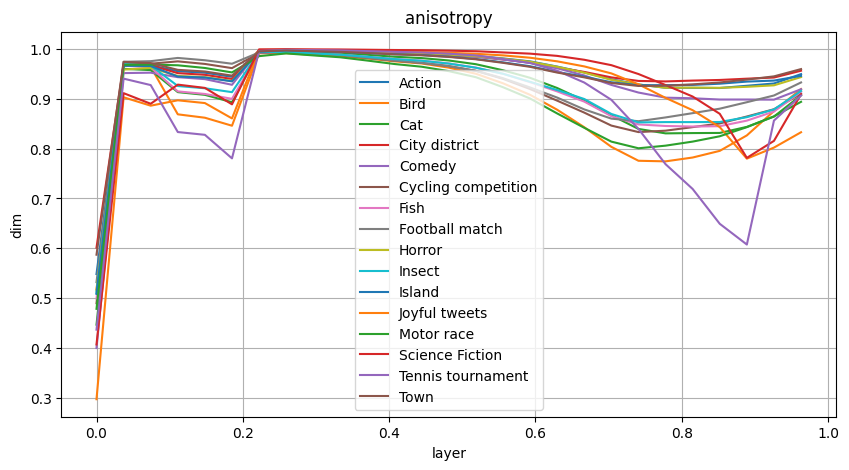

In [33]:
import matplotlib.pyplot as plt
def print_topics_stats(
        topics: list[str] = None,
        stat_name:str = 'twoNN_dim',
        selected_concepts : list[str] = None,
        ymax = None
):
    fig, ax = plt.subplots(figsize = (10, 5))

    ax.set(
        title = stat_name
    )
    for filename in os.listdir('all_stats'):
        if 'topic' in filename:
            name = filename[filename.find('topic')+len('topic')+1:]
            if selected_concepts is not None and name[:-5] not in selected_concepts:
                continue
            if topics is not None and name in topics:
                continue
        else:
            continue

        with open(f'all_stats/{filename}', 'r') as f:
            data = yaml.safe_load(f)

        ax.plot(get_relative_depth(data[stat_name]), data[stat_name], label = f'{name[:-5]}')

    ax.set(
        xlabel = 'layer',
        ylabel = 'dim'
    )
    if ymax is not None:
        ax.set_ylim(ymax=ymax)
    ax.grid()
    ax.legend()
    plt.show()

#print_topics_stats(selected_concepts=['Horror', 'Action', 'Comedy', 'Science Fiction'])
#print_topics_stats(selected_concepts=['Bird', 'Cat', 'Fish', 'Insect'])
#print_topics_stats(selected_concepts=['City district', 'Town', 'Island', 'Village'])
#print_topics_stats(selected_concepts=['Football match', 'Cycling competition', 'Motor race', 'Tennis tournament'])
#print_topics_stats()
#print_topics_stats(stat_name = 'singular_dim_09', ymax = 20)
print_topics_stats(stat_name = 'anisotropy')

In [ ]:
# MRPC
# 

### Размерности

In [19]:
with open('all_stats/openLlama3B_MRPC.yaml', 'r') as f:
    llama_stats = yaml.safe_load(f)

with open('all_stats/qwen2.5-3B_MRPC.yaml', 'r') as f:
    qwen_stats = yaml.safe_load(f)
    
with open('all_stats/bloom-2B5.yaml', 'r') as f:
    bloom_2b_stats = yaml.safe_load(f)

with open('all_stats/bloom-1b1.yaml', 'r') as f:
    bloom_1b_stats = yaml.safe_load(f)
    
with open('all_stats/bloom-560m.yaml', 'r') as f:
    bloom_560m_stats = yaml.safe_load(f)

with open('all_stats/bloom-7B1.yaml', 'r') as f:
    bloom_7b_stats = yaml.safe_load(f)

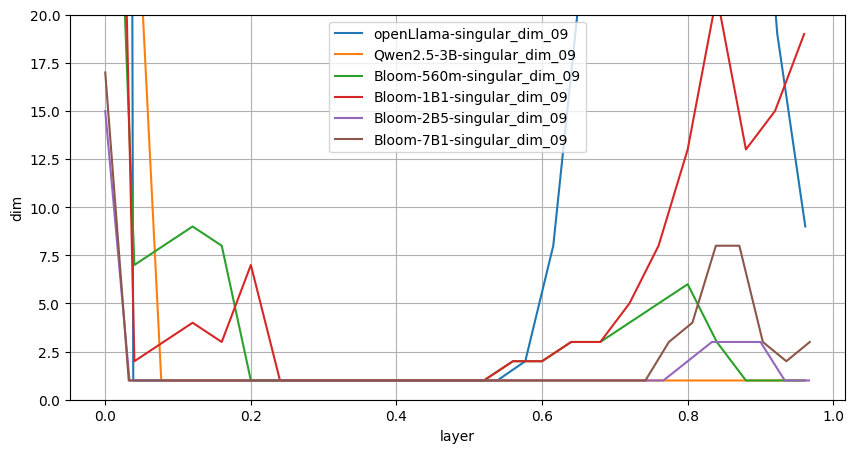

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 5))

for stats, label in zip([llama_stats, qwen_stats, bloom_560m_stats, bloom_1b_stats, bloom_2b_stats, bloom_7b_stats], 
                        ['openLlama', 'Qwen2.5-3B', 'Bloom-560m', 'Bloom-1B1', 'Bloom-2B5', 'Bloom-7B1']):
    ax.plot(get_relative_depth(stats['twoNN_dim']), stats['singular_dim_09'], label = f'{label}-singular_dim_09')

ax.set(
    xlabel = 'layer',
    ylabel = 'dim'
)
#ax.set_xticks(np.arange(26))
ax.grid()
ax.set_ylim(top = 20, bottom = 0)
ax.legend()
plt.show()

NameError: name 'llama_stats' is not defined

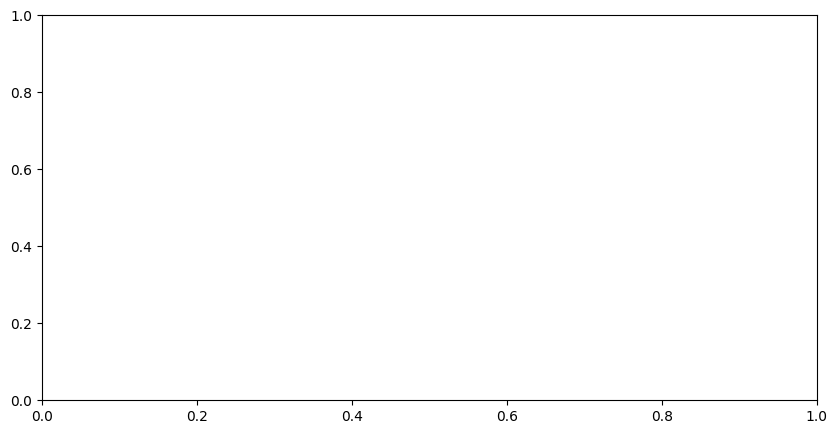

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 5))
for stats, label in zip([llama_stats, qwen_stats, bloom_560m_stats, bloom_1b_stats, bloom_2b_stats, bloom_7b_stats], 
                        ['openLlama', 'Qwen2.5-3B', 'Bloom-560m', 'Bloom-1B1', 'Bloom-2B5', 'Bloom-7B1']):
    ax.plot(get_relative_depth(stats['twoNN_dim']), stats['twoNN_dim'], label = f'{label}-twoNN_dim')
ax.set(
    xlabel = 'layer',
    ylabel = 'dim'
)
#ax.set_xticks(np.arange(26))
ax.grid()
ax.legend()
plt.show()

# MRPC
# sentence 1: .....

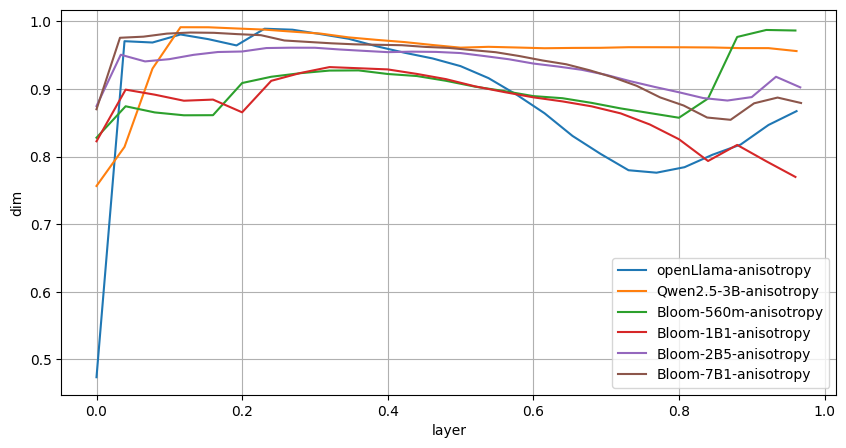

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 5))
for stats, label in zip([llama_stats, qwen_stats, bloom_560m_stats, bloom_1b_stats, bloom_2b_stats, bloom_7b_stats], 
                        ['openLlama', 'Qwen2.5-3B', 'Bloom-560m', 'Bloom-1B1', 'Bloom-2B5', 'Bloom-7B1']):
    ax.plot(get_relative_depth(stats['anisotropy']), stats['anisotropy'], label = f'{label}-anisotropy')
ax.set(
    xlabel = 'layer',
    ylabel = 'dim'
)
#ax.set_xticks(np.arange(26))
ax.grid()
ax.legend()
plt.show()